In [1]:
from contextlib import AbstractContextManager
import rich
import torch
import numpy as np
import pyro
from pyro import distributions as dist
from pyro import poutine
from pyro.infer import Trace_ELBO, TraceEnum_ELBO, SVI
from pyro.infer import config_enumerate, infer_discrete
from pyro.distributions import constraints
from pyro.ops.indexing import Vindex
from pyro.infer.autoguide import AutoNormal, AutoDelta, AutoGuide
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline


class catch(AbstractContextManager):
    def __init__(self, info = None):
        self.info = info

    def __enter__(self):
        if self.info is not None:
            print(f"=== {self.info} ===")

    def __exit__(self, exctype, excinst, exctb):
        if exctype is not None:
            print(f"Error: {exctype}")
        return True


def render_model_plus(model, model_args=None):
    display.display(
        pyro.render_model(model, model_args, render_params=True, render_distributions=True)
    )


## basics

In [ ]:
"""
Some differences between `param` and `sample`:
- different shapes:
    - for Normal, sample(param(shape=[5, 2]))=[5, 2]
    - for Categorical, sample(param(shape=[5, 2]))=[5]
- static vs dynamic: 
    - `param` will be reused if not `clear_param_store`
"""

print("=== param ===")
pyro.clear_param_store()
print(pyro.param("p", torch.randn(3, 3).exp(), constraint=constraints.simplex).shape)
print(pyro.param("p", torch.randn(5, 4, 3, 2).exp(), constraint=constraints.simplex).shape)
pyro.clear_param_store()
print(pyro.param("p", torch.randn(5, 4, 3, 2).exp(), constraint=constraints.simplex).shape)

print("=== sample ===")
print(pyro.sample("p", dist.Normal(0., 1.).expand([5, 2])).shape)
print(pyro.sample("p", dist.Normal(0., 1.).expand([3, 2])).shape)

In [ ]:
"""
    AutoNormal creates a Normal(loc, scale) for each param
"""
pyro.clear_param_store()

def model():
    p = pyro.param("loc", torch.tensor(0.0))
    x = pyro.sample("x", dist.Normal(p, 1))
    y = pyro.sample("y", dist.Normal(x, 1))

render_model_plus(model)
render_model_plus(AutoNormal(model))
render_model_plus(AutoDelta(model))

In [ ]:
"""
    Be careful about the shape of a distribution!

    Categorical(shape=[5, 2])'s batch_shape is [5]
    Normal(shape=[5, 2])'s batch_shape is [5, 2]
"""

def print_shape(some_dist: dist.Distribution):
    print("Shape: ", some_dist.batch_shape, some_dist.event_shape)

print("=== Normal ===")
print_shape(dist.Normal(0., 10.))
print_shape(dist.Normal(0., 10.).expand([5, 2]))
print_shape(dist.Normal(0., 10.).expand([5, 2]).to_event(1))

def cat(*shape):
    return dist.Categorical(torch.randn(*shape).exp())

print("=== Categorical ===")
print_shape(cat(5))
print_shape(cat(2).expand([5]))
print_shape(cat(5, 2))

In [ ]:
"""
    Distribution contains `batch_shape` and `event_shape`, represented by [batch_shape | event_shape]
    
    The constraint must be satisfied:
        plate's size = Distribution's batch_shape[dim]
"""
with pyro.plate('k', size=2, dim=None): 
    normal = dist.Normal(0., 10.)
    with catch("无法给 [3, 4 | ] 设置 size=2 的维度"):
        x = pyro.sample('x', normal.expand([3, 4]))
        print(x.shape) 
    with catch("可以给 [ | 3, 4] 设置 size=2 的维度，偷偷做了 broadcast"):
        x = pyro.sample('x', normal.expand([3, 4]).to_event(2))
        print(x.shape)
    with catch("无法给 [2, 4 | ] 设置 size=2 的维度"):
        x = pyro.sample('x', normal.expand([2, 4]))
        print(x.shape)
    with catch("可以给 [2 | 4] 设置 size=2 的维度"):
        x = pyro.sample('x', normal.expand([2, 4]).to_event(1))
        print(x.shape)
    

## poutines

In [ ]:
"""
    trace & replay
"""
def model_1(x):
    s = pyro.param("s", torch.tensor(0.5))
    z = pyro.sample("z", dist.Normal(x, s))
    print(f"[model_1] draw z = {z}")

def model_2(x):
    z = pyro.sample("z", dist.Normal(x, 4))
    print(f"[model_2] draw z = {z}")
    z2 = pyro.sample("z2", dist.Normal(x, 4))
    print(f"[model_2] draw z2 = {z2}")

print("=== Vanilla behaviour ===")
print("model_1 and model_2 should sample very different z:")
model_1(1.0)
model_2(1000.0)

print("=== Traced behaviour ===")
print("If we replay model_1's trace in model_2, `sample` will be deterministic:")
trace_model_1 = pyro.poutine.trace(model_1)
model_1_trace = trace_model_1.get_trace(1.0)
replayed_model_2 = pyro.poutine.replay(model_2, trace=model_1_trace)
replayed_model_2(1000.0)


In [ ]:
"""
    block makes some site invisible
    condition = sample(obs=~)
"""
def model():
    a = pyro.sample("a", dist.Normal(0., 1.))
    b = pyro.sample("b", dist.Normal(a, 1.))

pyro.render_model(poutine.block(model, expose=['b']))
pyro.render_model(poutine.condition(model, data={"b": torch.tensor(1.0)}))

In [ ]:
"""
    We construct the graph in model(),
        but we can modify it with `poutine.condition` to make some variables visible
        concretely, the process is:
            - sample x from N(0, 1)
            - set y to be 1 (but we view it as a sample from N(x, 1))
            - sample z from N(x, y)
        we can compute all log-probs (by a sampling path, not marginalized)!
"""
def model():
    x = pyro.sample("x", dist.Normal(0, 1))
    y = pyro.sample("y", dist.Normal(x, 1))
    z = pyro.sample("z", dist.Normal(x, y))
    print("log-prob-sum should be:",
          dist.Normal(0, 1).log_prob(x) +  #
          dist.Normal(x, 1).log_prob(y) +  #
          dist.Normal(x, y).log_prob(z))


obs_y_model = poutine.condition(model, data={"y": torch.tensor(1.0)})
trace = poutine.trace(obs_y_model).get_trace()
print("traced log-prob-sum:", trace.log_prob_sum())

## training



In [23]:
"""
    If we use AutoGuide, pyro will forward the model to know what the graph looks like,
    such that it can build a guide graph.

    So the model run TWICE in the first call to `svi.step()`
"""
def model(data):
    print(data)
    loc = pyro.sample("weights", dist.Normal(0.0, 1.0))
    scale = pyro.sample("scale", dist.LogNormal(0.0, 10.0))
    with pyro.plate("data", len(data)):
        obs_dist = dist.Normal(loc, scale)
        obs = pyro.sample("obs", obs_dist, obs=data)

def custom_guide(data):
    loc = pyro.sample("weights", dist.Normal(0.0, 1.0))
    scale = pyro.sample("scale", dist.LogNormal(0.0, 10.0))

data = torch.tensor([0, 1, 2, 11, 12, 13, 14, 15])
pyro.clear_param_store()

auto_guide = AutoDelta(model)
elbo = Trace_ELBO()
opt = pyro.optim.AdamW({"lr": 0.1})


for name, guide in {"custom_guide": custom_guide, "auto_guide": auto_guide}.items():
    print(f"Using {name}")
    svi = SVI(model, guide, opt, elbo)

    for i in range(3):
        print(f"Step {i}")
        svi.step(data)


Using custom_guide
Step 0
tensor([ 0,  1,  2, 11, 12, 13, 14, 15])
Step 1
tensor([ 0,  1,  2, 11, 12, 13, 14, 15])
Step 2
tensor([ 0,  1,  2, 11, 12, 13, 14, 15])
Using auto_guide
Step 0
tensor([ 0,  1,  2, 11, 12, 13, 14, 15])
tensor([ 0,  1,  2, 11, 12, 13, 14, 15])
Step 1
tensor([ 0,  1,  2, 11, 12, 13, 14, 15])
Step 2
tensor([ 0,  1,  2, 11, 12, 13, 14, 15])


## Enumerate
-----

### Toy Example

In [24]:
"""
    enumerate only works for distributions, which are:
        - NOT observed
        - discrete
    
    enumerate's effect:
        sample: [num_data] -> enumerate: [num_categories, 1] (the last is left for batch)

"""
@config_enumerate
def model(data):
    weights = pyro.sample("weights", dist.Dirichlet(0.5 * torch.ones(2)))
    with pyro.plate("components", 2):
        loc = pyro.sample("loc", dist.Normal(5, 3))
        scale = pyro.sample("scale", dist.LogNormal(0, 3))
    # ↑ For continious distribution, the shape is same before/after enumerate.
    # print(weights.shape, loc.shape, scale.shape)
    with pyro.plate("data", len(data)):
        # ↓ For discrete distribution (Categorical), [8] (w/o enumerate) -> [2, 1] (w/ enumerate)
        # The key here is: for each data point, if we sample a component individually
        # for each data, we have to sample |data| times. However:
        #   - sampling too early prevents us from marginalization
        #   - most of the sampling cause redundant computation (|components| << |data|)
        assignment = pyro.sample("assignment", dist.Categorical(weights))
        obs_dist = dist.Normal(loc[assignment], scale[assignment])
        obs = pyro.sample("obs", obs_dist, obs=data)
        print(assignment.shape, obs_dist.batch_shape, obs.shape)

data = torch.tensor([0, 1, 2, 11, 12, 13, 14, 15])
pyro.clear_param_store()

guide = AutoDelta(poutine.block(model, hide=['assignment']))
elbo = TraceEnum_ELBO(num_particles=1)
opt = pyro.optim.AdamW({"lr": 0.1})
svi = SVI(model, guide, opt, elbo)

for i in range(3):
    print(f"Step {i}")
    svi.step(data)

Step 0
torch.Size([8]) torch.Size([8]) torch.Size([8])
torch.Size([8]) torch.Size([8]) torch.Size([8])
torch.Size([2, 1]) torch.Size([2, 1]) torch.Size([8])
Step 1
torch.Size([2, 1]) torch.Size([2, 1]) torch.Size([8])
Step 2
torch.Size([2, 1]) torch.Size([2, 1]) torch.Size([8])


In [28]:
"""
    What should I comment here?
"""
@config_enumerate
def model():
    p = pyro.param("p", torch.randn(5, 4, 3, 2).exp(), constraint=constraints.simplex)
    x = pyro.sample("x", dist.Categorical(torch.ones(4)))
    y = pyro.sample("y", dist.Categorical(torch.ones(3)))
    with pyro.plate("z_plate", 5):
        p_xy = Vindex(p)[..., x, y, :]
        z = pyro.sample("z", dist.Categorical(p_xy))
    print(f"     p.shape = {p.shape}")
    print(f"     x.shape = {x.shape}")
    print(f"     y.shape = {y.shape}")
    print(f"  p_xy.shape = {p_xy.shape}")
    print(f"     z.shape = {z.shape}")
    return x, y, z

def guide():
    pass

pyro.clear_param_store()
print("=== Sampling ===")
model()
print("=== Enumerated Inference ===")
elbo = TraceEnum_ELBO()
elbo.loss(model, guide)


=== Sampling ===
     p.shape = torch.Size([5, 4, 3, 2])
     x.shape = torch.Size([])
     y.shape = torch.Size([])
  p_xy.shape = torch.Size([5, 2])
     z.shape = torch.Size([5])
=== Enumerated Inference ===
     p.shape = torch.Size([5, 4, 3, 2])
     x.shape = torch.Size([])
     y.shape = torch.Size([])
  p_xy.shape = torch.Size([5, 2])
     z.shape = torch.Size([5])
     p.shape = torch.Size([5, 4, 3, 2])
     x.shape = torch.Size([4, 1])
     y.shape = torch.Size([3, 1, 1])
  p_xy.shape = torch.Size([3, 4, 5, 2])
     z.shape = torch.Size([2, 1, 1, 1])


-0.0

### vindex

In [30]:
"""
    vanilla indexing
"""

x = torch.rand(2, 4, 5, 6)


print("=== CASE I: scalar indexing ===")
# take the slice of x where 
#   2nd-dim is 0 and 4th-dim is 0
# return a slice whose shape is
#   [2, 5]
y = x[..., 0, :, 0]
print(y.shape)

print("=== CASE II: vector indexing ===")
# take the slice of x where 
#   2nd-dim is 0 and 4th-dim is 3
#   2nd-dim is 1 and 4th-dim is 1
#   2nd-dim is 1 and 4th-dim is 2
# return 3 slices whose shape is
#   [3, 2, 5]
y = x[..., torch.tensor([0, 1, 1]), :, torch.tensor([3, 1, 2])]
print(y.shape)
print(y[0] - x[:, 0, :, 3])

print("=== CASE III: vector indexing with broadcasting ===")
# take the slice of x where 
#   2nd-dim is 0 and 4th-dim is 3
#   2nd-dim is 1 and 4th-dim is 3
#   2nd-dim is 1 and 4th-dim is 3
# return 3 slices whose shape is
#   [3, 2, 5]
y = x[..., torch.tensor([0, 1, 1]), :, torch.tensor([3])]
print(y.shape)
print(y[1] - x[:, 1, :, 3])

=== CASE I: scalar indexing ===
torch.Size([2, 5])
=== CASE II: vector indexing ===
torch.Size([3, 2, 5])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
=== CASE III: vector indexing with broadcasting ===
torch.Size([3, 2, 5])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [31]:
"""
    v-index (or batch indexing)

    KEY: ellipse(...) denote batch dimension!
"""

x = torch.rand(2, 4, 5, 6)

print("=== CASE I: trivial case ===")
# batch_index_select
#   x[0]'s shape is [4, 5, 6], index select by [0] and [3]
#   x[1]'s shape is [4, 5, 6], index select by [2] and [2]
y = Vindex(x)[..., torch.tensor([0, 2]), :, torch.tensor([3, 2])]
print(y.shape)
print(y[0] - x[0, 0, :, 3])
print(y[1] - x[1, 2, :, 2])

print("=== CASE II: broadcasting original tensor ===")
# shape:
#   x  is [2 | 4 5 6]
#   i1 is [2 2]
#   i2 is [2 2]
# broadcast:
#   x's shape [_ 2 | 4 5 6 ]-> [2 2 | 4 5 6]
# finally:
#   y[i, j] = x[i, j, i1[i][j], :, i2[i][j]]
y = Vindex(x)[..., torch.tensor([[0, 2], [0, 3]]), :, torch.tensor([[3, 2], [3, 2]])]
print(y.shape)
print(y[0][0] - x[0, 0, :, 3])
print(y[0][1] - x[1, 2, :, 2])
print(y[1][0] - x[0, 0, :, 3])
print(y[1][1] - x[1, 3, :, 2])


print("=== CASE III: broadcasting index tensor")
# shape:
#   x  is [7 2 | 4 5 6]
#   i1 is [2]
#   i2 is [2]
# broadcast:
#   i's shape [_ 2]-> [7 2]
# finally:
x = torch.rand(7, 2, 4, 5, 6)
y = Vindex(x)[..., torch.tensor([0, 2]), :, torch.tensor([3, 2])]
print(y.shape)
print(y[5][0] - x[5, 0, 0, :, 3])
print(y[2][1] - x[2, 1, 2, :, 2])


print("=== CASE III: broadcasting both")
# shape:
#   x  is [2 | 4 5 6]
#   i1 is [2 1]
#   i2 is [2 1]
# broadcast:
#   x's shape [2 | 4 5 6] -> [2 2 | 4 5 6]
#   i's shape [2 1] -> [2 2]
#   NOTE: [2] + [2, 1]? == [2, 2], != [2, 1]
# finally:
#   - x[<0>, i, 0, :, 3] == y[0, i]
x = torch.rand(2, 4, 5, 6)
y = Vindex(x)[..., torch.tensor([[0], [2]]), :, torch.tensor([[3], [2]])]
print(y.shape)
i = 1
print(y[0, i] - x[i, 0, :, 3])
print(y[1, i] - x[i, 2, :, 2])

=== CASE I: trivial case ===
torch.Size([2, 5])
tensor([0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0.])
=== CASE II: broadcasting original tensor ===
torch.Size([2, 2, 5])
tensor([0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0.])
=== CASE III: broadcasting index tensor
torch.Size([7, 2, 5])
tensor([0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0.])
=== CASE III: broadcasting both
torch.Size([2, 2, 5])
tensor([0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0.])


### Gaussian Mixture Model

In [29]:
"""
    We marginalize all possible assignments in the model.
    
"""
@config_enumerate
def model(data, num_components=2):
    weights = pyro.sample("weights", dist.Dirichlet(0.5 * torch.ones(num_components)))
    with pyro.plate("components", num_components):
        loc = pyro.sample("loc", dist.Normal(5, 3))
        scale = torch.tensor([1.0, 1.0])
    with pyro.plate("data", len(data)):
        # for each datum (more precisely, `for i in range(len(data))` 
        #   since the datum is not observed yet)
        assignment = pyro.sample("assignment", dist.Categorical(weights))
        obs_dist = dist.Normal(loc[assignment], scale[assignment])
        obs = pyro.sample("obs", obs_dist, obs=data)

data = torch.tensor([0, 1, 2, 11, 12, 13, 14, 15])
pyro.clear_param_store()

guide = AutoDelta(poutine.block(model, hide=['assignment']))
elbo = TraceEnum_ELBO(num_particles=1)
opt = pyro.optim.AdamW({"lr": 0.1})
svi = SVI(model, guide, opt, elbo)

print(f"ELBO before: {elbo.loss(model, guide, data)}")

# train
losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)
# plt.plot(losses)
# plt.show()

print(f"ELBO after: {elbo.loss(model, guide, data)}")

rich.print(dict(pyro.get_param_store()))

# render_model_plus(model, (data, ))
# render_model_plus(guide, (data, ))

print("=== Sampling ===")
model(data)

print("=== MAP ===")
map_model = infer_discrete(model, first_available_dim=-2, temperature=0)
rich.print(dict(poutine.trace(map_model).get_trace(data).nodes)['assignment']['value'])
# pyro.render_model(map, (data, ), render_params=True)

ELBO before: 186.62033081054688
ELBO after: 27.53680419921875


{
    'AutoDelta.weights': tensor([0.6428, 0.3572], grad_fn=<DivBackward0>),
    'AutoDelta.loc': Parameter containing:
tensor([12.6208,  1.1366], requires_grad=True)
}

=== Sampling ===
=== MAP ===


tensor([0, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
"""
    In the guide trained before, the assignment is not determined, since it will be marginalized in the model.

    Two ways to train a guide to approximate the posterior:
        - Fix the trained cluster centers, only train the assignment for each data.
        - Use a guide with all possible assignments!

"""
@config_enumerate
def full_guide(data):
    # Global variables
    # We can keep our learned values of global parameters:
    # with poutine.block(hide_types=["param"]):  
    #     guide(data)
    guide(data)

    # Local variables
    with pyro.plate('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), 2) / 2,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))

pyro.clear_param_store()
optim = pyro.optim.AdamW({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, full_guide, optim, loss=elbo)

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)
plt.plot(losses)

rich.print(dict(pyro.get_param_store()))


### Hidden Markov Model

None
Dummy Step 1
c torch.Size([256]) torch.Size([256])
x torch.Size([256]) torch.Size([256])
c torch.Size([256]) torch.Size([256])
x torch.Size([256]) torch.Size([256])
c torch.Size([2, 1]) torch.Size([2, 1, 1])
x torch.Size([256]) torch.Size([256])
Dummy Step 2
c torch.Size([2, 1]) torch.Size([2, 1, 1])
x torch.Size([256]) torch.Size([256])


{
    'state': tensor([0.1388, 0.8612], grad_fn=<DivBackward0>),
    'trans': tensor([[0.8908, 0.1092],
        [0.2324, 0.7676]], grad_fn=<DivBackward0>),
    'emiss': tensor([[0.2189, 0.1434, 0.6377],
        [0.7290, 0.2238, 0.0472]], grad_fn=<DivBackward0>)
}

{
    'state': tensor([0.9000, 0.1000]),
    'trans': tensor([[0.8000, 0.2000],
        [0.3000, 0.7000]]),
    'emiss': tensor([[0.7000, 0.2000, 0.1000],
        [0.1000, 0.2000, 0.7000]])
}

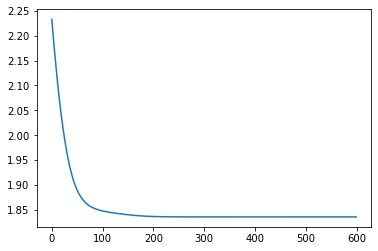

In [13]:
"""
    Design a HMM1 to generate the data and train a HMM2 to fit the data.

    - Everything is discrete, use `enumerate` for marginalization!
    - The HMM2 will fit the data, but it does not mean it has the same parameter
        as HMM1. The generated distributions will be close.
"""
COVID_PARAM = dict(
    state = torch.tensor(
        [0.9, 0.1]    # negative, positive
    ),
    trans = torch.tensor([
        [0.8, 0.2],
        [0.3, 0.7]    
    ]),
    emiss = torch.tensor([
        [0.7, 0.2, 0.1],   # 家, 隔离点, 方仓
        [0.1, 0.2, 0.7]
    ])
)

def covid(x):
    state, trans, emiss = COVID_PARAM['state'], COVID_PARAM['trans'], COVID_PARAM['emiss']
    with pyro.plate("data", len(x)):
        c1 = pyro.sample("c1", dist.Categorical(state))
        c2 = pyro.sample("c2", dist.Categorical(trans[c1]))
        x1 = pyro.sample("x1", dist.Categorical(emiss[c1]))
        x2 = pyro.sample("x2", dist.Categorical(emiss[c2]))
        return torch.stack([x1, x2], dim=-1)

@config_enumerate
def model(data, debug):
    state = pyro.param("state", torch.rand(2), constraints.simplex)
    trans = pyro.param("trans", torch.rand(2, 2), constraints.simplex)
    emiss = pyro.param("emiss", torch.rand(2, 3), constraints.simplex)
    # state = pyro.param('state', COVID_PARAM['state'].clone(), constraints.simplex)
    # trans = pyro.param('trans', COVID_PARAM['trans'].clone(), constraints.simplex)
    # emiss = pyro.param('emiss', COVID_PARAM['emiss'].clone(), constraints.simplex)
    with pyro.plate("data", size=len(data)):
        c1 = pyro.sample("c1", dist.Categorical(state))
        c2 = pyro.sample("c2", dist.Categorical(trans[c1]))
        x1 = pyro.sample("x1", dist.Categorical(emiss[c1]))
        x2 = pyro.sample("x2", dist.Categorical(emiss[c2]))
        if debug:
            print("c", c1.shape, c2.shape)
            print("x", x1.shape, x2.shape)
            return torch.stack([x1, x2], dim=-1)

data = covid(list(range(256)))

pyro.clear_param_store()

cond_model = poutine.condition(model, data={"x1": data[:, 0], "x2": data[:, 1]})
# render_model_plus(cond_model, (data, False))
guide = AutoDelta(poutine.block(model, hide=['c1', 'c2', 'x1', 'x2']))
# render_model_plus(guide, (data, False))

elbo = TraceEnum_ELBO()
opt = pyro.optim.AdamW({"lr": 0.01})
svi = SVI(cond_model, guide, opt, elbo)

# dummy step
print("Dummy Step 1")
svi.step(data, True)
print("Dummy Step 2")
svi.step(data, True)

# training
losses = []
for i in range(600):
    # print(f"Step {i}")
    loss = svi.step(data, False)
    losses.append(loss / len(data))
plt.plot(losses)
rich.print(dict(pyro.get_param_store()))
rich.print(COVID_PARAM)

out = list(map(tuple, model(data, True).tolist()))
real = list(map(tuple, data.tolist()))

print("=== Generated Distribution ===")
from collections import Counter
print(Counter(out))
print(Counter(real))